<a href="https://colab.research.google.com/github/fralfaro/MAT306/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT306 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [3]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [4]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [5]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT306/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [13]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



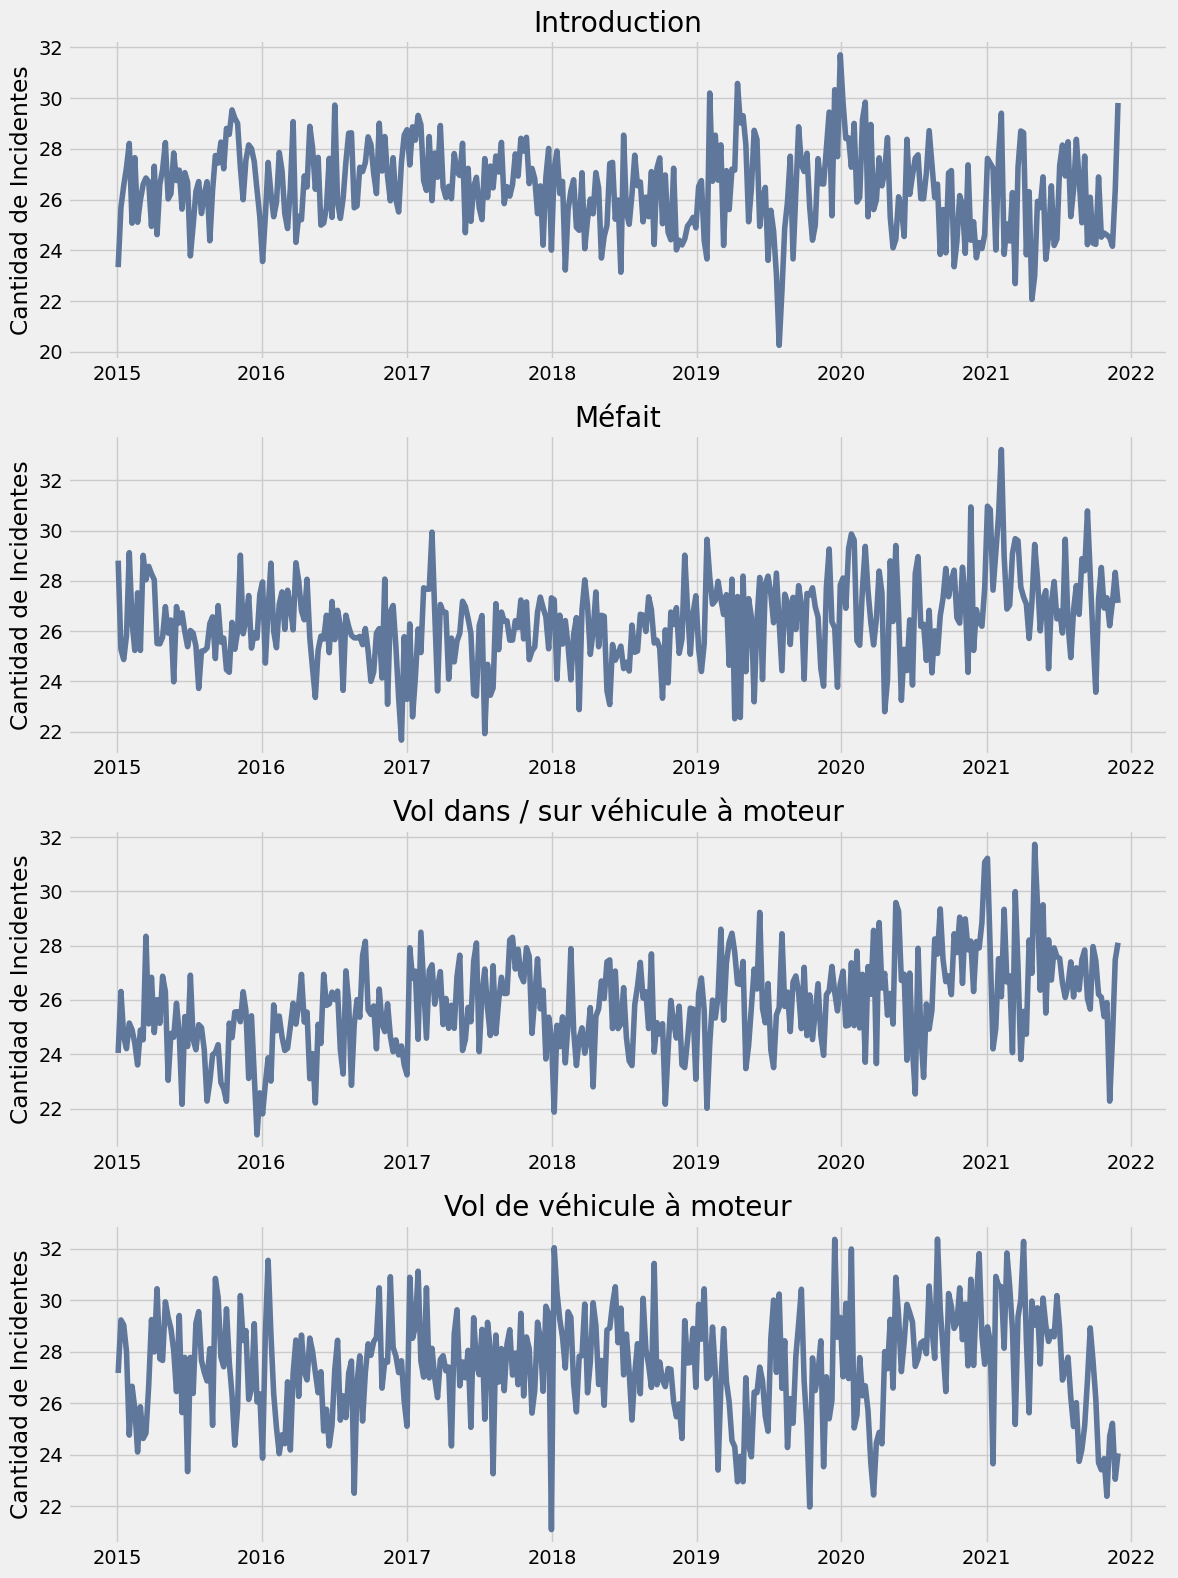

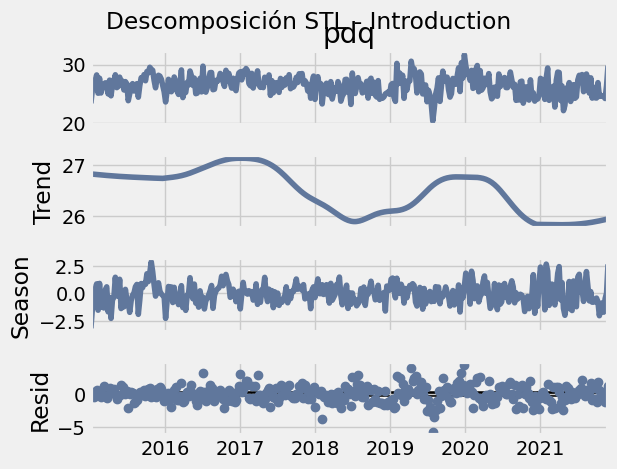

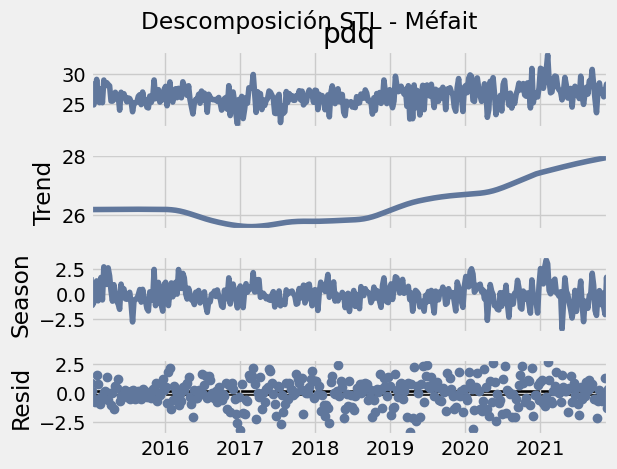

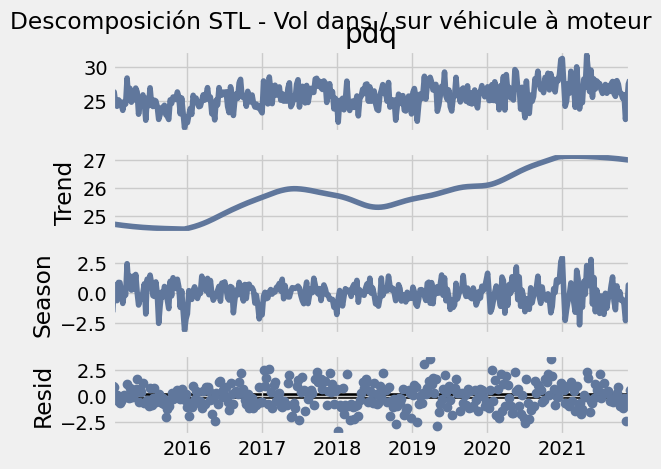

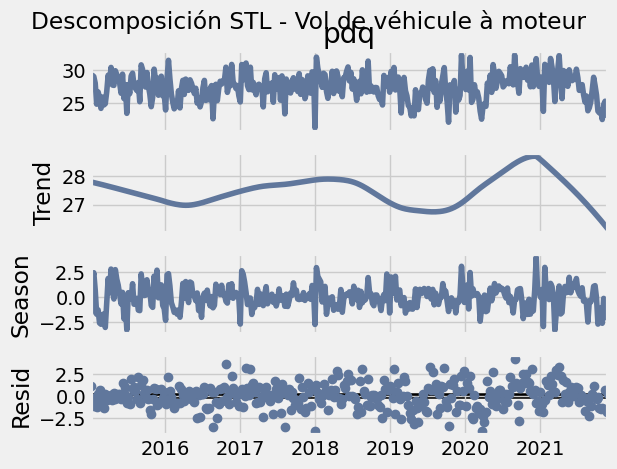

In [14]:
fig, axes = plt.subplots(4, 1, figsize=(12, 16))

axes[0].plot(y_s1['pdq'])
axes[0].set_title(validate_categorie[0])
axes[0].set_ylabel('Cantidad de Incidentes')

axes[1].plot(y_s2['pdq'])
axes[1].set_title(validate_categorie[1])
axes[1].set_ylabel('Cantidad de Incidentes')

axes[2].plot(y_s3['pdq'])
axes[2].set_title(validate_categorie[2])
axes[2].set_ylabel('Cantidad de Incidentes')

axes[3].plot(y_s4['pdq'])
axes[3].set_title(validate_categorie[3])
axes[3].set_ylabel('Cantidad de Incidentes')

plt.tight_layout()
plt.show()


from statsmodels.tsa.seasonal import STL

for i, serie in enumerate([y_s1, y_s2, y_s3, y_s4]):
    stl = STL(serie['pdq'], period=52).fit()
    fig = stl.plot()
    fig.suptitle(f"Descomposición STL - {validate_categorie[i]}")
    plt.show()



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [15]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

Consideraremos la serie y_s2, es decir, la segunda serie temporal. La cual se muestra a continuación, junto con su autocorrelación.

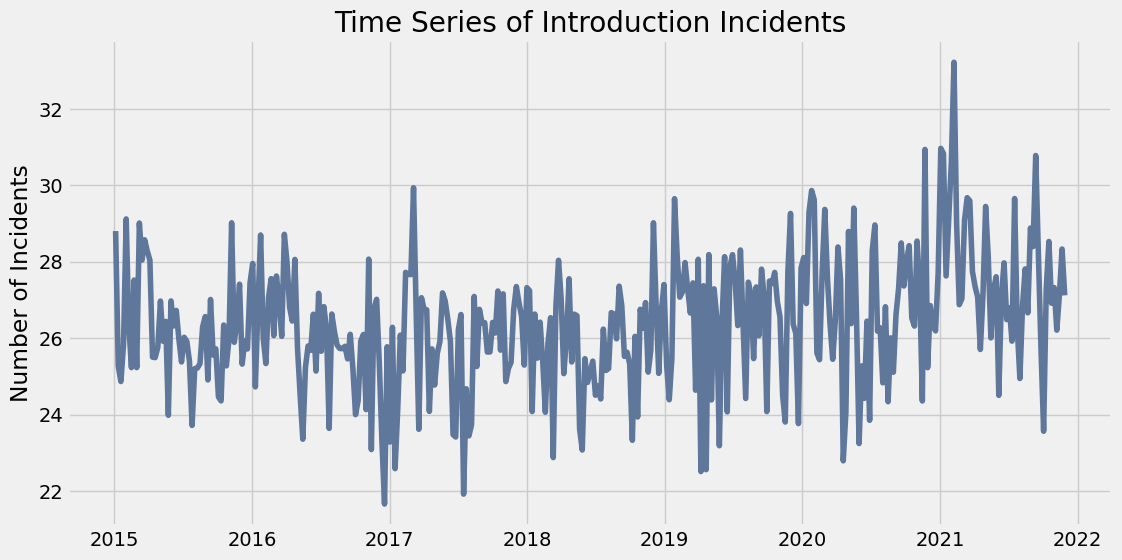

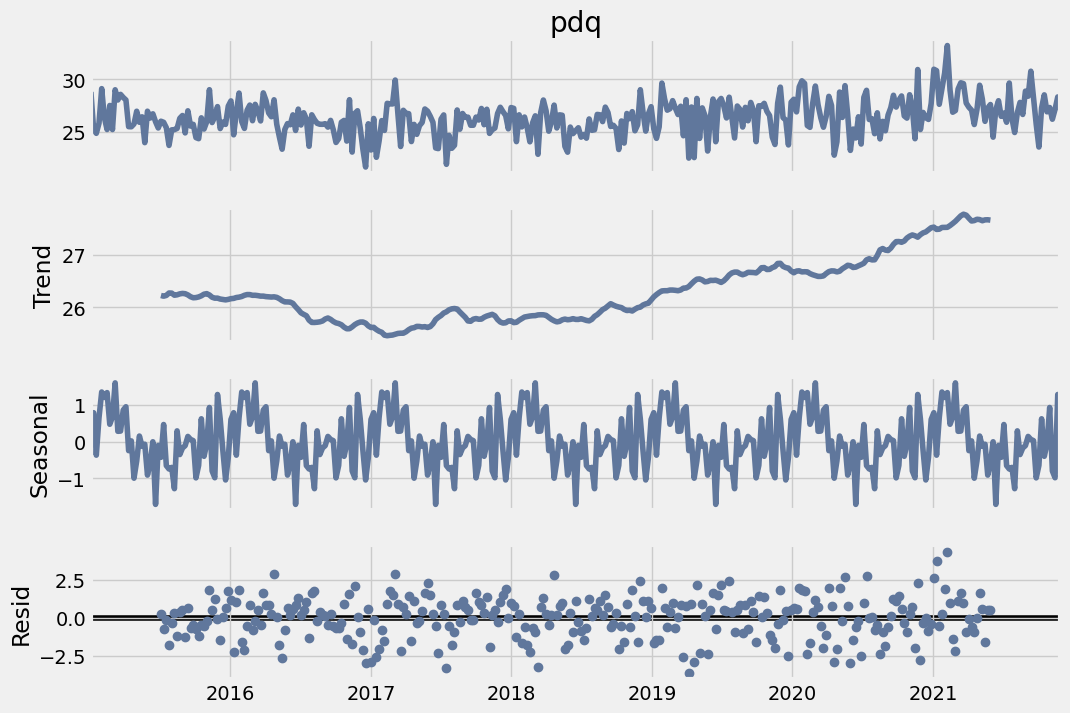

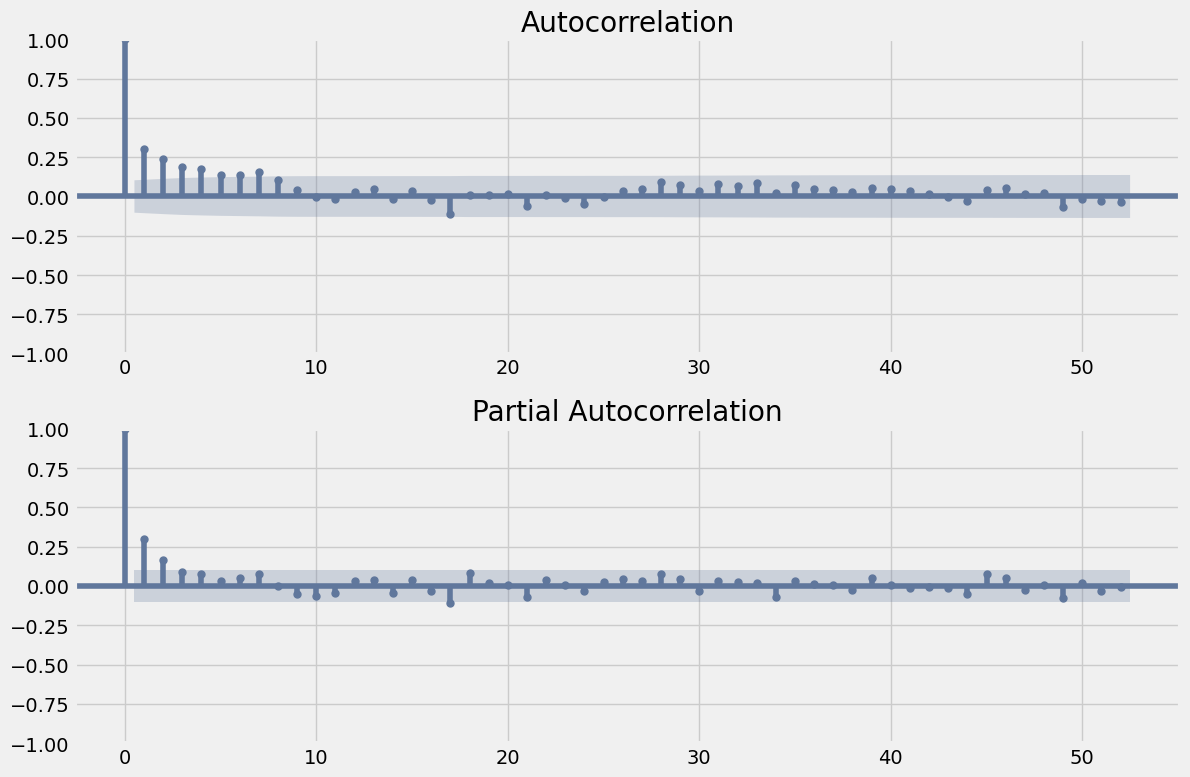

ADF Statistic: -5.434942
p-value: 0.000003
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


In [16]:
plt.figure(figsize=(12, 6))
plt.plot(y_s2['pdq'])
plt.title('Time Series of Introduction Incidents')
plt.ylabel('Number of Incidents')
plt.show()

decomposition = sm.tsa.seasonal_decompose(y_s2['pdq'], model='additive')
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(y_s1['pdq'], lags=52, ax=axes[0])
sm.graphics.tsa.plot_pacf(y_s1['pdq'], lags=52, ax=axes[1])
plt.tight_layout()
plt.show()

from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(y_s2['pdq'])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

Luego, procedemos a ajuste un modelo $SARIMA(p,d,q) \times (P,D,Q,S)$ probando distintas configuraciones de hiperparámetros.
Compararemos resultados, seleccione la mejor configuración y justifique su elección.

In [17]:
import warnings
warnings.filterwarnings("ignore")

df_metrics = pd.DataFrame()

for param in params:
    try:
        sarima_model = SarimaModels(param)
        metrics_df = sarima_model.metrics(y_s2, target_date)
        df_metrics = pd.concat([df_metrics, metrics_df], ignore_index=True)
    except Exception as e:
        print(f"Could not fit SARIMA model for {param}: {e}")

display(df_metrics)

df_metrics.sort_values(by='rmse', ascending=True).head(1)

,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,27.7622,773.9341,27.8197,1.0000,0.7854,1.0000,0.9651,2.0000,"SARIMA_(0,0,0)X(0,0,0,12)"
1,24.1010,618.8685,24.8771,0.8744,0.7022,0.8681,0.8436,1.6744,"SARIMA_(0,0,0)X(0,0,1,12)"
2,1.9778,7.0173,2.6490,0.0703,0.0699,0.0712,0.0679,0.0715,"SARIMA_(0,0,0)X(0,1,0,12)"
3,1.9204,6.0707,2.4639,0.0668,0.0665,0.0692,0.0645,0.0699,"SARIMA_(0,0,0)X(0,1,1,12)"
4,2.0343,7.1918,2.6818,0.0722,0.0717,0.0733,0.0697,0.0739,"SARIMA_(0,0,0)X(1,0,0,12)"
...,...,...,...,...,...,...,...,...,...
59,1.5198,4.4674,2.1136,0.0530,0.0528,0.0547,0.0512,0.0547,"SARIMA_(1,1,1)X(0,1,1,12)"
60,1.5314,4.2455,2.0605,0.0533,0.0532,0.0552,0.0515,0.0551,"SARIMA_(1,1,1)X(1,0,0,12)"
61,1.5280,4.2301,2.0567,0.0532,0.0530,0.0550,0.0514,0.0550,"SARIMA_(1,1,1)X(1,0,1,12)"
62,1.7964,5.8076,2.4099,0.0633,0.0630,0.0647,0.0612,0.0651,"SARIMA_(1,1,1)X(1,1,0,12)"


,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
21,1.3736,3.1533,1.7758,0.0493,0.0491,0.0495,0.0476,0.0493,"SARIMA_(0,1,0)X(1,0,1,12)"


Podemos notar que el modelo que nos entrega un menor rmse es el modelo SARIMA_(0,1,0)x(1,0,1,12).
Ahora procedemos a realizar una validación del modelo, considerando el mejor modelo que ya elegimos.

,21
mae,1.3736
mse,3.1533
rmse,1.7758
mape,0.0493
maape,0.0491
wmape,0.0495
mmape,0.0476
smape,0.0493
model,"SARIMA_(0,1,0)X(1,0,1,12)"



Residual Analysis of the Best Model:


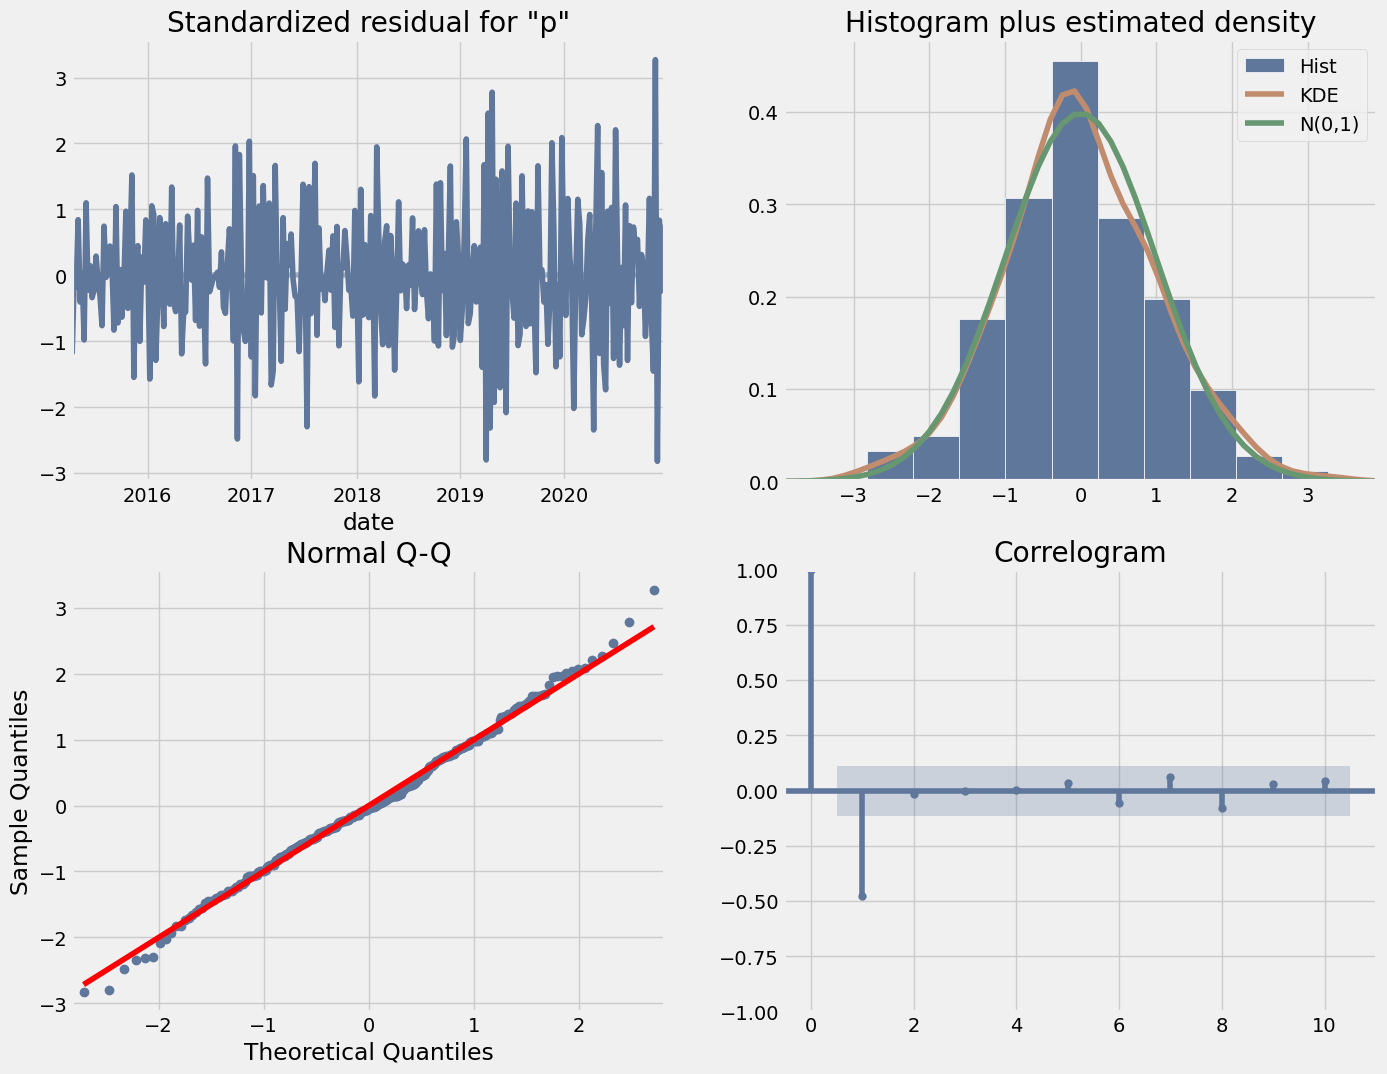

In [18]:
best_model_metrics = df_metrics.loc[df_metrics['rmse'].idxmin()]
display(best_model_metrics)

best_param_str = best_model_metrics['model'].replace('SARIMA_', '').replace('X', ',')
import re
matches = re.match(r'\((\d+),(\d+),(\d+)\),\((\d+),(\d+),(\d+),(\d+)\)', best_param_str)
best_pdq = (int(matches.group(1)), int(matches.group(2)), int(matches.group(3)))
best_seasonal_pdq = (int(matches.group(4)), int(matches.group(5)), int(matches.group(6)), int(matches.group(7)))
best_param = (best_pdq, best_seasonal_pdq)

best_sarima_model = SarimaModels(best_param)
best_model_fit = best_sarima_model.fit_model(y_s2, target_date)

print("\nResidual Analysis of the Best Model:")
best_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


Podemos apreciar residuos que tienden a ser normales, lo cual nos sirve como afirmación como una buena elección del modelo.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [26]:
pip install prophet cmdstanpy --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 89.8 MB/s eta 0:00:00
  Attempting uninstall: prophet
    Found existing installation: prophet 1.1.7
    Uninstalling prophet-1.1.7:
      Successfully uninstalled prophet-1.1.7


In [19]:
from prophet import Prophet

In [27]:
prophet_df = y_s2['pdq'].reset_index()
prophet_df.columns = ['ds', 'y']

train_prophet_df = prophet_df[prophet_df['ds'] < target_date]
test_prophet_df = prophet_df[prophet_df['ds'] >= target_date]

model = Prophet()
model.fit(train_prophet_df)

future = model.make_future_dataframe(periods=len(test_prophet_df), freq='W')
forecast = model.predict(future)

prophet_preds = forecast[['ds', 'yhat']].set_index('ds')
prophet_preds = prophet_preds.loc[test_prophet_df['ds']]
prophet_preds.columns = ['yhat']

prophet_results_df = test_prophet_df.set_index('ds').copy()
prophet_results_df['yhat'] = prophet_preds['yhat']

prophet_metrics = summary_metrics(prophet_results_df)
prophet_metrics['model'] = 'Prophet'

display(prophet_metrics)

display(best_model_metrics)

print("\nComparacion entre Prophet y SARIMA:")
print("Prophet generalmente maneja mejor estacionalidad y es mas facil, ya que es un par de lineas y tienes un modelo")
print("SARIMA requiere mas conociminetos de este tema ademas de entender como seleccion los parametros pero gracias a esto tambien permite un analisis mas personal y profundo de los datos")
print(f"Prophet RMSE: {prophet_metrics['rmse'].iloc[0]}")
print(f"SARIMA RMSE: {best_model_metrics['rmse']}")



INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.2731,2.9623,1.7211,0.0447,0.0446,0.0459,0.0432,0.0456,Prophet


,21
mae,1.3736
mse,3.1533
rmse,1.7758
mape,0.0493
maape,0.0491
wmape,0.0495
mmape,0.0476
smape,0.0493
model,"SARIMA_(0,1,0)X(1,0,1,12)"



Comparacion entre Prophet y SARIMA:
Prophet generalmente maneja mejor estacionalidad y es mas facil, ya que es un par de lineas y tienes un modelo
SARIMA requiere mas conociminetos de este tema ademas de entender como seleccion los parametros pero gracias a esto tambien permite un analisis mas personal y profundo de los datos
Prophet RMSE: 1.7211
SARIMA RMSE: 1.7758

Conlusiones:
Prophet en general prefiere datos con una estacionalidad y tendencia clara, es mas bien simple comparado a todo el analisis que se hacer con SARIMA


Podemos notar que si analizamos comportamientos complejos a largo plazo, Prophet te da interpretabilidad y flexibilidad.
Pero, por otro lado si nuestro foco es precisión estadística y control sobre la estructura temporal, SARIMA es más adecuado.